In [1]:
# Import necessary libraries
import os
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow import optimizers
from keras import layers, models
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from lxml import etree
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import xml.etree.ElementTree as ET


In [2]:
# Define paths to annotation and image directories
annotations_dir = "C:\\Users\\mazen\\Desktop\\archive\\imagess\\img-annotations"
images_dir = "C:\\Users\\mazen\\Desktop\\archive\\imagess\\image"

# Define classes
classes = ['With Helmet', 'Without Helmet']

In [3]:
# Parse XML annotations
def parse_annotation(annotation_file):
    tree = etree.parse(annotation_file)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text), int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text), int(bbox.find('ymax').text)]
        objects.append(obj_struct)
    return objects



In [8]:
# Load images and annotations
def load_data(annotations_dir, images_dir):
    i=0
    X, y = [], []
    for annotation_file in os.listdir(annotations_dir):
        if i>535:
            return
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            objects = parse_annotation(annotation_path)
            image_path = os.path.join(images_dir, annotation_file.replace('.xml', '.png'))
            image = load_img(image_path, target_size=(224, 224))
            image = img_to_array(image)
            X.append(preprocess_input(image))
            labels = [0] * len(classes)
            for obj in objects:
                label_idx = classes.index(obj['name'])
                labels[label_idx] = 1
            y.append(labels)
            i=i+1
    return np.array(X), np.array(y)
# Load and preprocess data
X_train, y_train = load_data(annotations_dir, images_dir)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6432 - loss: 0.8345
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 837ms/step - accuracy: 0.8711 - loss: 0.3628
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 813ms/step - accuracy: 0.9595 - loss: 0.2041
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 809ms/step - accuracy: 0.9392 - loss: 0.1592
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 798ms/step - accuracy: 0.9542 - loss: 0.1449
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 807ms/step - accuracy: 0.9374 - loss: 0.1534
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 856ms/step - accuracy: 0.9458 - loss: 0.1404
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 887ms/step - accuracy: 0.9454 - loss: 0.1482
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 774ms/step - accuracy: 0.9270 - loss: 0.2125
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 826ms/step - accuracy: 0.9371 - loss: 0.1411


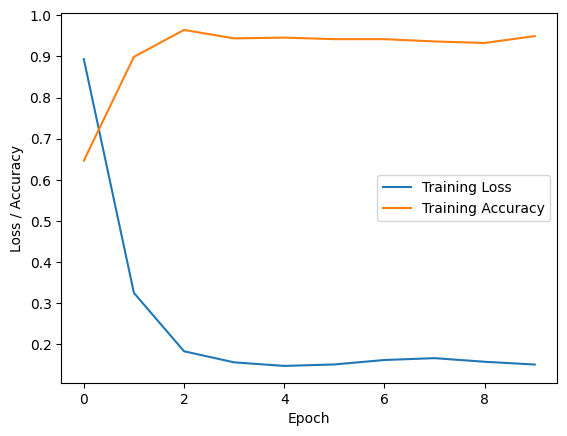

In [9]:
# Define the CNN model
model = models.Sequential()

# Adding first convolutional layer with pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Adding second convolutional layer with pooling
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Adding flattening layer
model.add(layers.Flatten())

# Adding a fully connected layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(classes), activation='softmax'))

# Compiling the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),  # learning rate 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fitting the CNN to the images
history = model.fit(X_train, y_train, epochs=10, batch_size=32)  

# Plot training history to visualize loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

In [ ]:
# Save the model
saved_model_dir = "C:\\Users\\mazen\\Desktop\\savedmodel2.h5"
model.save(saved_model_dir)
print("Model saved successfully at:", saved_model_dir)

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model("C:\\Users\\mazen\\Desktop\\savedmodel2.h5")

# Function to preprocess the input image
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Function to parse the XML annotation
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        return obj.find('name').text  # Return the class label

# Path to validation images and annotations
validation_images_dir = "C:\\Users\\mazen\\Desktop\\archive\\validation\\val-image"
validation_annotations_dir = "C:\\Users\\mazen\\Desktop\\archive\\validation\\val-image-annotations"  

# Get all image filenames in the directory
image_filenames = os.listdir(validation_images_dir)

# Initialize lists to store actual and predicted labels
y_true = []
y_pred = []
# Make predictions on all validation images
for image_filename in image_filenames:
    image_path = os.path.join(validation_images_dir, image_filename)
    preprocessed_image = preprocess_image(image_path)
    prediction = loaded_model.predict(preprocessed_image)
    
    # Append actual and predicted labels to respective lists
    annotation_path = os.path.join(validation_annotations_dir, image_filename.replace('.png', '.xml'))
    actual_label = parse_annotation(annotation_path)  # Get the actual label from the XML annotation
    y_true.append(actual_label)
    predicted_label = classes[np.argmax(prediction)]  # Convert prediction to string label
    y_pred.append(predicted_label)

# Print classification report
print(classification_report(y_true, y_pred))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

In [ ]:
#testing cell
# Load the saved model
loaded_model = tf.keras.models.load_model("C:\\Users\\mazen\\Desktop\\savedmodel2.h5")

# Function to preprocess the input image
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image
# Function to make predictions on images
def predict_image(image_path, model):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    return prediction
# Path to test images
test_images_dir = "C:\\Users\\mazen\\Desktop\\archive\\test\\tst-image"

# Get all image filenames in the directory
image_filenames = os.listdir(test_images_dir)

# Make predictions on all test images
for image_filename in image_filenames:
    image_path = os.path.join(test_images_dir, image_filename)
    prediction = predict_image(image_path, loaded_model)
    print("Prediction for", image_filename, ":", prediction)


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import vgg16
# Define paths
saved_model_dir = "C:\\Users\\mazen\\Desktop\\savedmodel2.h5"

# Load the saved model
model = load_model(saved_model_dir)

# Define classes
classes = ['With Helmet', 'Without Helmet']

# Define a function to preprocess input image
def preprocess_input(image):
    # Preprocess the image for VGG16 model
    return vgg16.preprocess_input(image)
# Define a function to visualize predictions
def visualize_predictions(image_path):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
      # Make prediction
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    
    # Display the image and prediction
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted: {classes[predicted_class]}")
    plt.axis('off')
    plt.show()